## Third Approach: Re-sampling with SMOTE

In this approach, we will use the **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm to balance the dataset. SMOTE generates synthetic samples for the minority class to balance the dataset. First, we will oversample the minority class **Enrolled**, then we will train a model using the balanced dataset. Additionally, we will perform other experiments, such as oversampling the other minority class **Dropout** and undersampling the majority class **Graduated**.

The SMOTE algorithm is described in the following paper: [SMOTE: Synthetic Minority Over-sampling Technique](https://www.jair.org/index.php/jair/article/view/10302/24590). In this paper, the authors present the algorithm and demonstrate how this technique of oversampling the minority class is superior to traditional oversampling techniques, which simply duplicate the samples of the minority class.

Below is the pseudo-code for a two-class problem:

```julia
Algorithm SMOTE(T, N, k)
Input:
    T = Number of minority class samples
    N = Percentage of oversampling (SMOTE percentage)
    k = Number of nearest neighbors

Output:
    (N/100) * T synthetic minority class samples

1. If N is less than 100%, randomize the minority class samples, as only a random percentage of them will be SMOTEd.
2. If N < 100 then
    3. Randomize the T minority class samples
    4. T = (N / 100) * T
    5. N = 100
6. End if
7. N = (int)(N / 100) * T  (*The amount of SMOTE is assumed to be in integral multiples of 100.*)
8. k = Number of nearest neighbors
9. numattrs = Number of attributes
10. Sample[][]: Array for original minority class samples
11. newindex: Counter for number of synthetic samples, initialized to 0
12. Synthetic[][]: Array for synthetic samples

13. For i = 1 to T
    14. Compute k nearest neighbors for sample i, and save the indices in nnarray
    15. Populate(N, i, nnarray)
16. End for

Function Populate(N, i, nnarray):
17. While N > 0
    18. Choose a random number between 1 and k, call it nn. This step selects one of the k nearest neighbors of sample i.
    19. For each attribute (attr) from 1 to numattrs:
        20. Compute the difference: dif = Sample[nnarray[nn]][attr] - Sample[i][attr]
        21. Compute a random gap: gap = random number between 0 and 1
        22. Synthetic[newindex][attr] = Sample[i][attr] + gap * dif
    20. End for
    23. Increment newindex
    24. Decrement N
25. End while

26. Return synthetic samples
End of pseudo-code.
```


### Description of the used models

To be able to compare the results with the first and second approaches, we will use the same configuration of hyperparameters for the models:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


- Imbalanced-learn (revision): https://www.sciencedirect.com/science/article/pii/S0957417416307175?casa_token=lyglFt_Ye0YAAAAA:Apv_dixqX-GQm04rHLrN6wBhIRJHhxCFlqUS5WXXbuD-iJCO9FUBZ9VLAxgRDwUTKdpPTGgHIA
  - Aqui falan de SMOTE (tecnica para over-sampling), tecnicas de re-sampling híbridas e undersampling.
  - Tamén falan de que aplicando PCA e tecnicas de reducción da dimensionalidade se pode reducir o efecto negativo do desbalanceamento.
  - Tamén comentan que as técnicas de ensamblado se utilizan para estas situacións, pero me da que non vai poder ser aplicable ao noso caso (utilizan AdaBoost e esas vainas).
  - Por último, comentan que se poden utilizar técnicas para ponderar os erros. Guai se utilizamos unha rede neuronal, posto que so hai que cambiar a función de custo, pero implementa ti isto en SVM ou Decision Tree. É posible, de feito, hai formas e explicanse, pero implicaría cambiar o codigo drasticamente.
- Learning from imbalanced data (non o lin, pero creo que tamén describe técnicas de resampling): https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907


**Index**

- [Data loading](#Data-loading)
- [SMOTE configurations](#SMOTE-experiments)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble model](#Ensemble-model)
  - [Majority voting](#Majority-voting)
  - [Weighted voting](#Weighted-voting)
  - [Naive Bayes](#Naive-Bayes)
  - [Stacking](#Stacking)


## Data loading


In [1]:
using DataFrames
using CSV
using Random
using Serialization

In [2]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

generateComparisonTable (generic function with 2 methods)

In [3]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame);

# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [4]:
inputs = Float32.(Matrix(inputs))

# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

## SMOTE experiments

In the first approach we see that we detected some problems in some metrics because of the imbalance of the dataset. For example, for the ANN model, we get high values of mean accuracy and low values of mean F1-score. This happens because the precision and recall of the class `Enrolled` are very low.

<div style="display: flex; justify-content: center;">
<image src="plots/Approach1/ANN/accuracy_performance_bar.png" width="600"/>
<image src="plots/Approach1/ANN/f1_score_performance_bar.png" width="600"/>
</div>

To address this problem, we will use the SMOTE algorithm to balance the dataset. We will conduct 5 experiments:

- Oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Enrolled` at 200% and undersampling the majority class `Graduated` at 50%.

We are going to fix the number of nearest neighbors to 5.

To avoid retraining all the models multiple times, we will perform the experiments only with the base models: ANN, Decision Tree, SVM, and KNN, using the best hyperparameters identified in the first approach. Subsequently, we will train the models in the same manner as in the first approach, but with the balanced dataset that yielded the best results.


In [5]:
target_column = :Target
println("\nClass Distribution:")
println(combine(groupby(data, target_column), nrow => :Count))


Class Distribution:
3×2 DataFrame
 Row │ Target    Count 
     │ String15  Int64 
─────┼─────────────────
   1 │ Dropout    1421
   2 │ Graduate   2209
   3 │ Enrolled    794


In [79]:
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50)
]
k = 5

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for (i, smote_percentage) in enumerate(smote_percentages)
      println("\nSmote percentages: ", smote_percentage)
      balanced_inputs, balanced_targets = smote(inputs, targets, smote_percentage, k)
      println("Number of instances: ", size(balanced_targets)[1])
      println("Elements of class Dropout: ", sum(balanced_targets .== "Dropout"))
      println("Elements of class Graduate: ", sum(balanced_targets .== "Graduate"))
      println("Elements of class Enrolled: ", sum(balanced_targets .== "Enrolled"))
    end
  end
end


Smote percentages: Dict("Enrolled" => 200)
Number of instances: 5218
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300)
Number of instances: 6012
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Dropout" => 200)
Number of instances: 6639
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300, "Dropout" => 200)
Number of instances: 7433
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Graduate" => 50)
Number of instances: 4113
Elements of class Dropout: 1421
Elements of class Graduate: 1104
Elements of class Enrolled: 1588


In [91]:
# Best configurations
topology = [64, 23]
topology_scikit_ann = [64]
max_depth = 5
n_neighbors = 5
kernel = "linear"
C = 10

# ANN
hyperparameters_ann = Dict(
  "topology" => topology,
  "learningRate" => 0.01,
  "maxEpochs" => 100,
  "repetitionsTraining" => 10,
  "validationRatio" => 0.15,
  "maxEpochsVal" => 10,
  "minLoss" => 0.0001
)

# scikitANN
hyperparameters_scikit_ann = Dict(
  :hidden_layer_sizes => topology_scikit_ann,
  :learning_rate_init => 0.01,
  :max_iter => 100,
  :early_stopping => true,
  :tol => 0,
  :validation_fraction => 0.15,
  :n_iter_no_change => 10,
  :epsilon => 0.0001,
  :repetitionsTraining => 10
)

# DT
hyperparameters_dt = Dict(
  :max_depth => max_depth,
  :criterion => "gini",
  :min_samples_split => 2,
)

# SVM
hyperparameters_svm = Dict(
  :kernel => kernel,
  :C => C,
  :gamma => "auto",
  :probability => true,
)

# KNN
hyperparameters_knn = Dict(
  :n_neighbors => n_neighbors,
  :weights => "uniform",
  :metric => "euclidean",
)

# Define the hyperparameters for smote
k = 5
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50)
];

In [92]:
general_results_ann = []
class_results_ann = []
general_results_scikit_ann = []
class_results_scikit_ann = []
general_results_dt = []
class_results_dt = []
general_results_svm = []
class_results_svm = []
general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for smote_percentage in smote_percentages
      println("\nSmote percentage: ", smote_percentage)

      # ANN
      println("ANN")
      gr, cr = modelCrossValidation(
        :ANN,
        hyperparameters_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_ann, gr)
      push!(class_results_ann, cr)

      # Scikit ANN
      println("scikitANN")
      gr, cr = modelCrossValidation(
        :scikit_ANN,
        hyperparameters_scikit_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_scikit_ann, gr)
      push!(class_results_scikit_ann, cr)

      # DT
      println("DT")
      gr, cr = modelCrossValidation(
        :DT,
        hyperparameters_dt,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_dt, gr)
      push!(class_results_dt, cr)

      # SVM
      println("SVM")
      gr, cr = modelCrossValidation(
        :SVC,
        hyperparameters_svm,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_svm, gr)
      push!(class_results_svm, cr)

      # KNN
      println("KNN")
      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters_knn,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end


Smote percentage: Dict("Enrolled" => 200)
ANN
Mean accuracy: 0.49387 ± 0.01957
	Class 1: 0.42149 ± 0.04812
	Class 2: 0.45236 ± 0.01815
	Class 3: 0.73885 ± 0.04308
Mean precision: 0.19067 ± 0.02914
	Class 1: 0.21594 ± 0.01776
	Class 2: 0.19857 ± 0.06263
	Class 3: 0.12345 ± 0.03691
Mean recall: 0.30635 ± 0.02867
	Class 1: 0.51183 ± 0.11266
	Class 2: 0.22897 ± 0.08112
	Class 3: 0.15383 ± 0.06972
Mean f1_score: 0.19518 ± 0.026
	Class 1: 0.28298 ± 0.04802
	Class 2: 0.17577 ± 0.05908
	Class 3: 0.09202 ± 0.02632
scikitANN
Mean accuracy: 0.83368 ± 0.00567
	Class 1: 0.83673 ± 0.00954
	Class 2: 0.83848 ± 0.01376
	Class 3: 0.82123 ± 0.01364
Mean precision: 0.71762 ± 0.01809
	Class 1: 0.76684 ± 0.01574
	Class 2: 0.73992 ± 0.03296
	Class 3: 0.51064 ± 0.10655
Mean recall: 0.74822 ± 0.00928
	Class 1: 0.88177 ± 0.05983
	Class 2: 0.76375 ± 0.11113
	Class 3: 0.25777 ± 0.12173
Mean f1_score: 0.71789 ± 0.0125
	Class 1: 0.81946 ± 0.03501
	Class 2: 0.74123 ± 0.07956
	Class 3: 0.328 ± 0.11878
DT
Mean accura

In [94]:
# Save the results
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_smote_results.jl"

parameters = Dict("Enrolled" => [200, 300, 200, 300, 200], "Dropout" => [100, 100, 200, 200, 100], "Graduate" => [100, 100, 100, 100, 50])

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => parameters,
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => parameters,
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => parameters,
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => parameters,
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => parameters,
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [5]:
results_folder = "results/"
filename = results_folder * "3_smote_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

# As an example, print all the results again
for (algorithm, results) in loaded_obj
  println("Algorithm: ", algorithm)
  num_trained_models = results["num_trained_models"]
  println("Number of trained models: ", num_trained_models)
  general_results = results["general_results"]
  class_results = results["class_results"]
  parameters_names = keys(results["parameters"])
  parameters = results["parameters"]

  for i in 1:num_trained_models
    param_line = ""
    for param in parameters_names
      param_line *= param * ": " * string(parameters[param][i]) * ", "
    end
    println("\nModel ", i, ": ", param_line)
    gr = general_results[i]
    cr = class_results[i]
    for (metric, values) in gr
      println("Mean ", metric, ": ", round(mean(values), digits=5), " ± ", round(std(values), digits=5))
      for j in 1:length(cr)
        println("\tClass ", j, ": ", round(mean(cr[j][metric]), digits=5))
      end
    end
  end
end

Algorithm: DT
Number of trained models: 5

Model 1: Enrolled: 200, Graduate: 100, Dropout: 100, 
Mean recall: 0.72174 ± 0.01261
	Class 1: 0.84869
	Class 2: 0.82171
	Class 3: 0.10325
Mean f1_score: 0.67786 ± 0.01534
	Class 1: 0.78384
	Class 2: 0.78224
	Class 3: 0.16133
Mean precision: 0.6771 ± 0.02992
	Class 1: 0.73543
	Class 2: 0.75354
	Class 3: 0.38505
Mean accuracy: 0.81143 ± 0.00845
	Class 1: 0.80651
	Class 2: 0.82731
	Class 3: 0.80968

Model 2: Enrolled: 300, Graduate: 100, Dropout: 100, 
Mean recall: 0.72333 ± 0.01303
	Class 1: 0.85403
	Class 2: 0.82035
	Class 3: 0.10449
Mean f1_score: 0.67977 ± 0.0119
	Class 1: 0.78759
	Class 2: 0.78195
	Class 3: 0.16498
Mean precision: 0.68357 ± 0.02682
	Class 1: 0.73805
	Class 2: 0.75461
	Class 3: 0.41312
Mean accuracy: 0.81254 ± 0.0084
	Class 1: 0.80944
	Class 2: 0.82686
	Class 3: 0.81036

Model 3: Enrolled: 200, Graduate: 100, Dropout: 200, 
Mean recall: 0.52442 ± 0.02303
	Class 1: 0.97194
	Class 2: 0.10254
	Class 3: 0.06532
Mean f1_score: 0.

In [8]:
model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3)

(Any["DT", "KNN", "SVM", "scikit_ANN", "ANN"], [:accuracy, :precision, :recall, :f1_score], Dict{Symbol, Vector{Any}}(:recall => [0.5711579642495037, 0.654123521191651, 0.7311043538870661, 0.6997811207036341, 0.37231512772962594], :f1_score => [0.48911167449224857, 0.6563987067189878, 0.719936539844474, 0.6791914145944528, 0.28513471698644005], :precision => [0.6077056793421527, 0.6854180693712935, 0.7267123365719862, 0.7083658793364305, 0.2983255676897249], :accuracy => [0.6937762128970798, 0.7697016275860864, 0.8227530829464055, 0.7971671214865489, 0.5608102201872723]), Dict{Symbol, Vector{Any}}(:recall => [0.15276451799578486, 0.0627369977430783, 0.038993649453889, 0.08932456682058004, 0.11344317441942768], :f1_score => [0.18320475845499173, 0.05712715447318127, 0.0309372167156631, 0.0861621038669984, 0.1332048217423276], :precision => [0.07174010689157503, 0.014374057430895894, 0.01515480731500017, 0.0315176558369932, 0.1323591320290505], :accuracy => [0.11671874830417278, 0.041742

In [ ]:
# Plot metrics for each algorithm
plotMetricsAlgorithm(loaded_obj, output_dir="./plots/Approach3/", ylim=(0.6, 0.9))

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for scikit_ANN and accuracy.
Saved plots for scikit_ANN and precision.
Saved plots for scikit_ANN and recall.
Saved plots for scikit_ANN and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.


In [11]:
# Plot metrics for each class
plotMetricsAlgorithm(loaded_obj, 3, output_dir="./plots/Approach2/Classes", ylim=(0, 1))

Saved plots for DT and accuracy on Class 1.
Saved plots for DT and precision on Class 1.
Saved plots for DT and recall on Class 1.
Saved plots for DT and f1_score on Class 1.
Saved plots for DT and accuracy on Class 2.
Saved plots for DT and precision on Class 2.
Saved plots for DT and recall on Class 2.
Saved plots for DT and f1_score on Class 2.
Saved plots for DT and accuracy on Class 3.
Saved plots for DT and precision on Class 3.
Saved plots for DT and recall on Class 3.
Saved plots for DT and f1_score on Class 3.
Saved plots for KNN and accuracy on Class 1.
Saved plots for KNN and precision on Class 1.
Saved plots for KNN and recall on Class 1.
Saved plots for KNN and f1_score on Class 1.
Saved plots for KNN and accuracy on Class 2.
Saved plots for KNN and precision on Class 2.
Saved plots for KNN and recall on Class 2.
Saved plots for KNN and f1_score on Class 2.
Saved plots for KNN and accuracy on Class 3.
Saved plots for KNN and precision on Class 3.
Saved plots for KNN and re

In [9]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────────────────────────────┬──────────┬───────────┬──────────┬──────────┐
│                              Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────────────────────────────┼──────────┼───────────┼──────────┼──────────┤
│ Enrolled: 300, Graduate: 100, Dropout: 100 │ 0.822201 │  0.725251 │ 0.740113 │ 0.694453 │
│ Enrolled: 200, Graduate: 100, Dropout: 100 │ 0.819492 │  0.708763 │ 0.735593 │ 0.690277 │
│ Enrolled: 300, Graduate: 100, Dropout: 200 │  0.69092 │  0.615313 │ 0.548023 │ 0.459324 │
│ Enrolled: 200, Graduate: 100, Dropout: 200 │  0.66899 │  0.623298 │ 0.542373 │  0.43702 │
│  Enrolled: 200, Graduate: 50, Dropout: 100 │ 0.572574 │  0.624605 │ 0.414689 │ 0.344759 │
└────────────────────────────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach3/.

Comparison of Hyperparameter Configurations for KNN 

In [ ]:
# Generate tables for each algorithm for each class sorted by f1 score
generateAlgorithmTables(loaded_obj, 3, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/Classes")

MethodError: MethodError: no method matching generateAlgorithmTables(::Dict{Symbol, Dict{String, Any}}, ::Int64; sort_by::Symbol, rev::Bool, output_dir::String)
The function `generateAlgorithmTables` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  generateAlgorithmTables(::Dict{Symbol, Dict{String, Any}}; sort_by, rev, output_dir)
   @ Main c:\Users\NACHO\Desktop\Olga\Máster\Primer semestre\ML\Final-Project-MaLea\plotting.jl:328


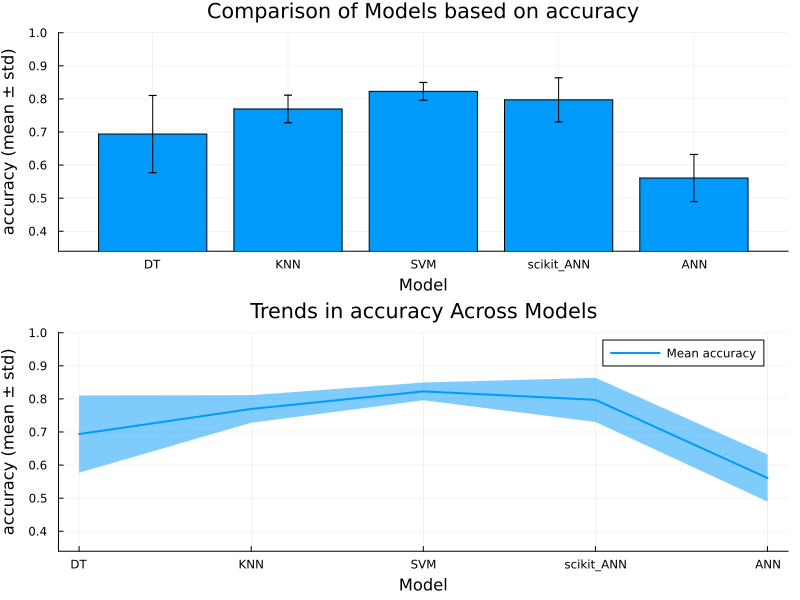

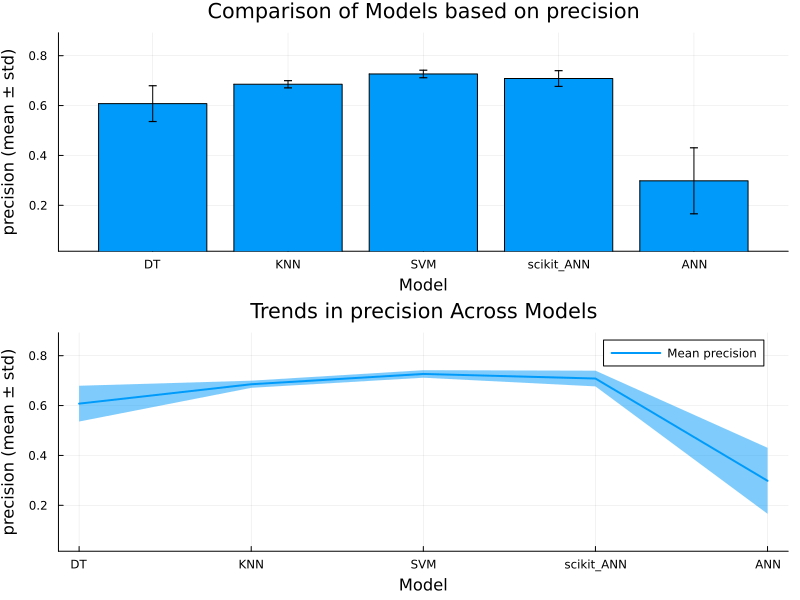

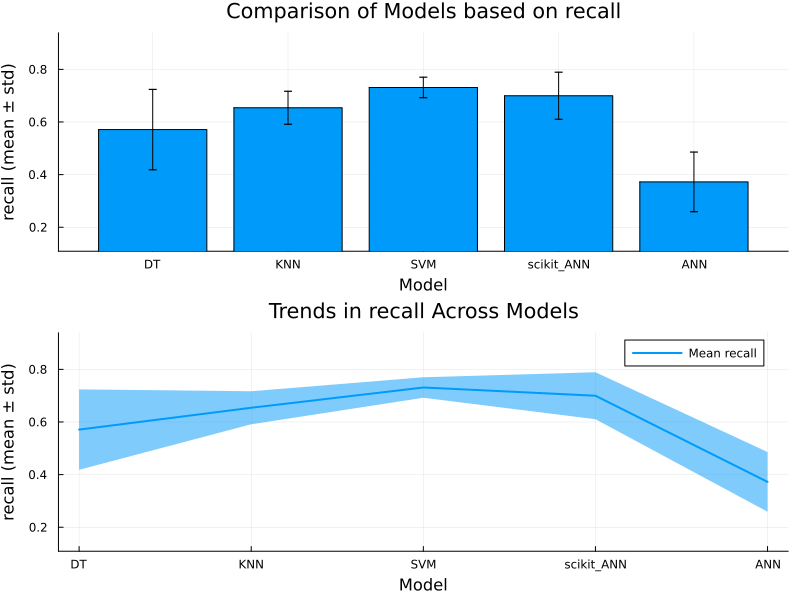

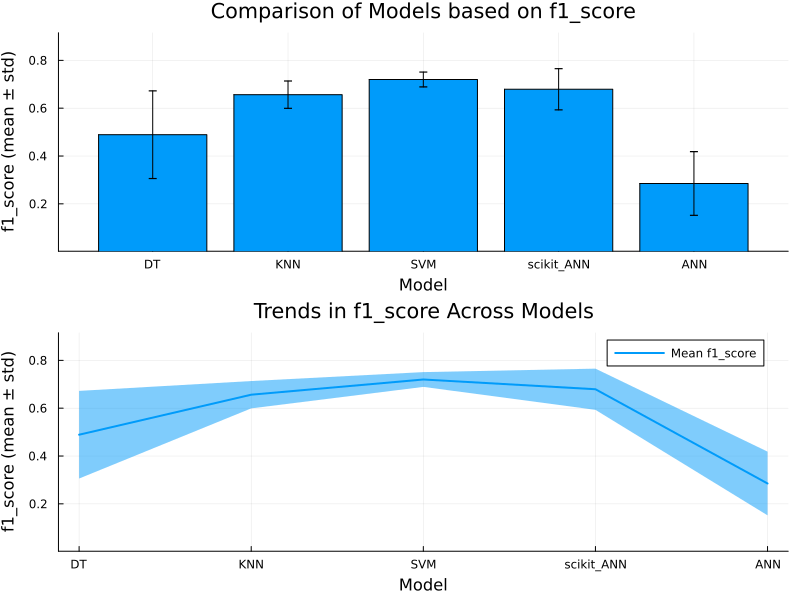

In [13]:
# Plot combined bar and line metrics
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots/Approach3/", show=true, ylim=(0.6, 0.9))

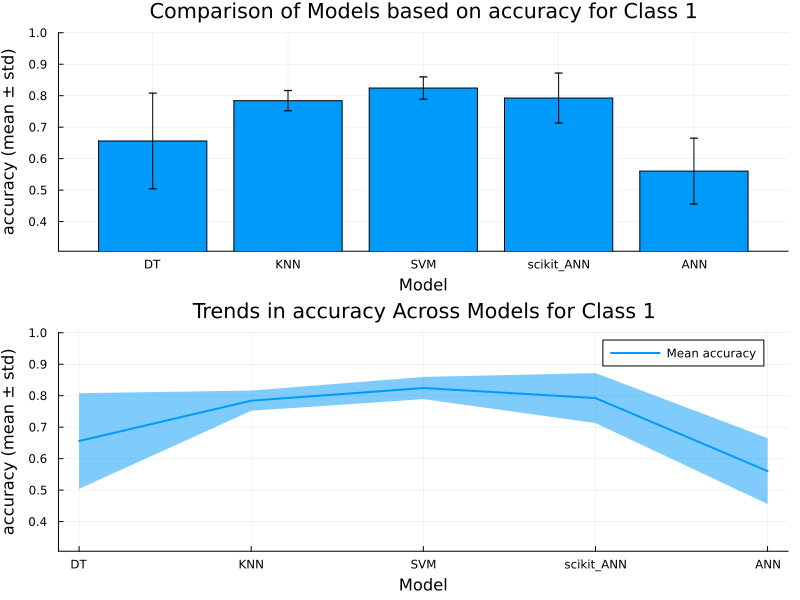

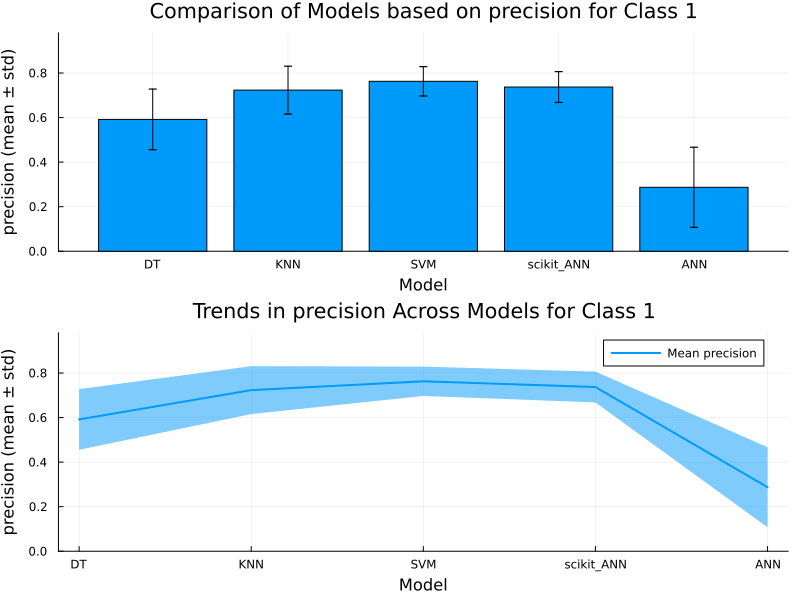

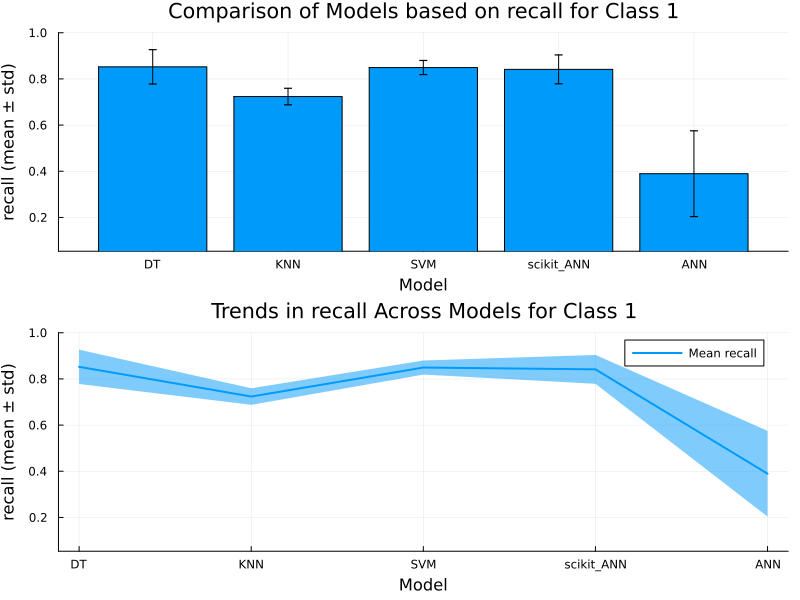

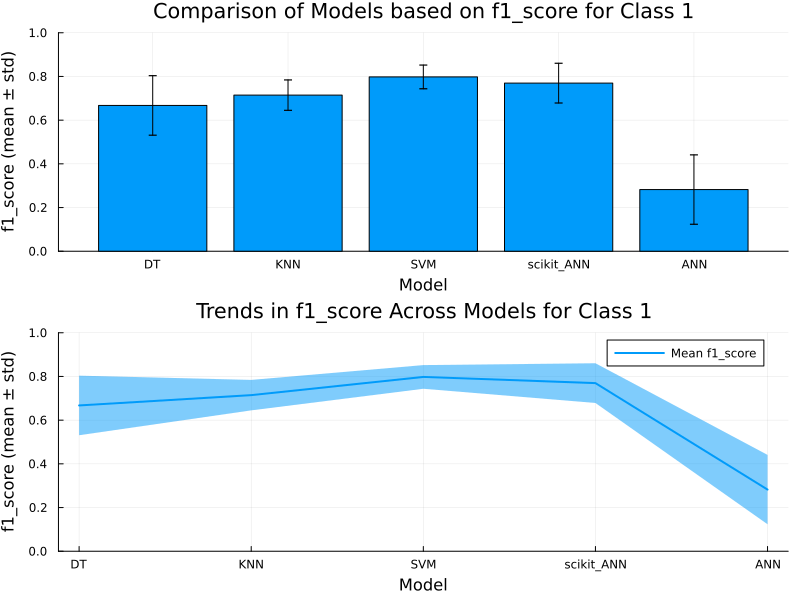

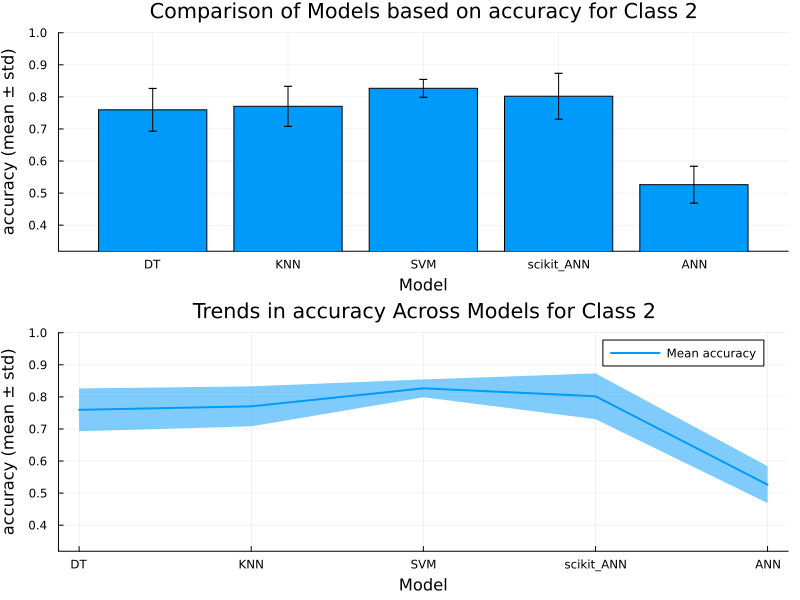

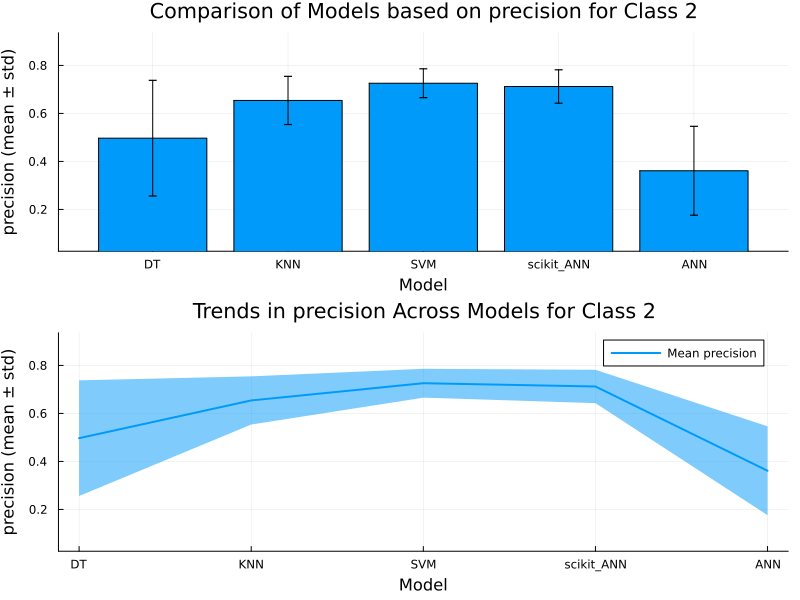

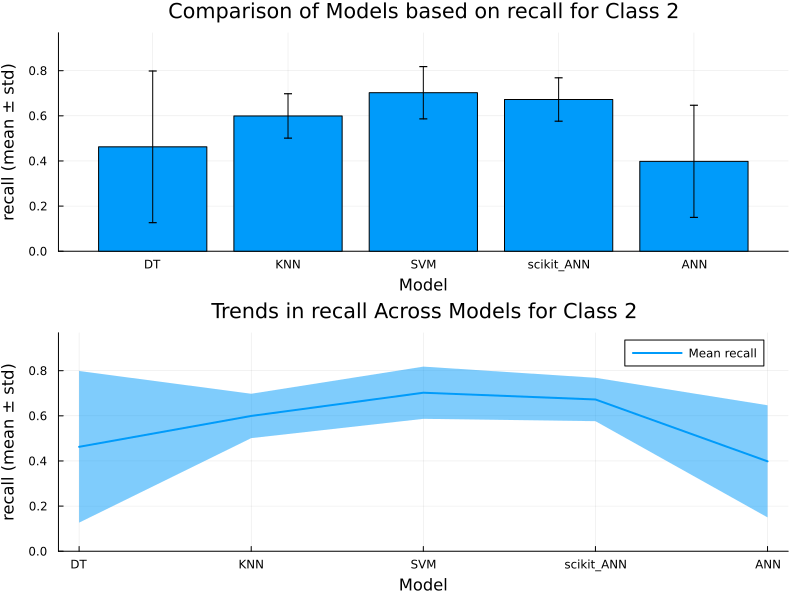

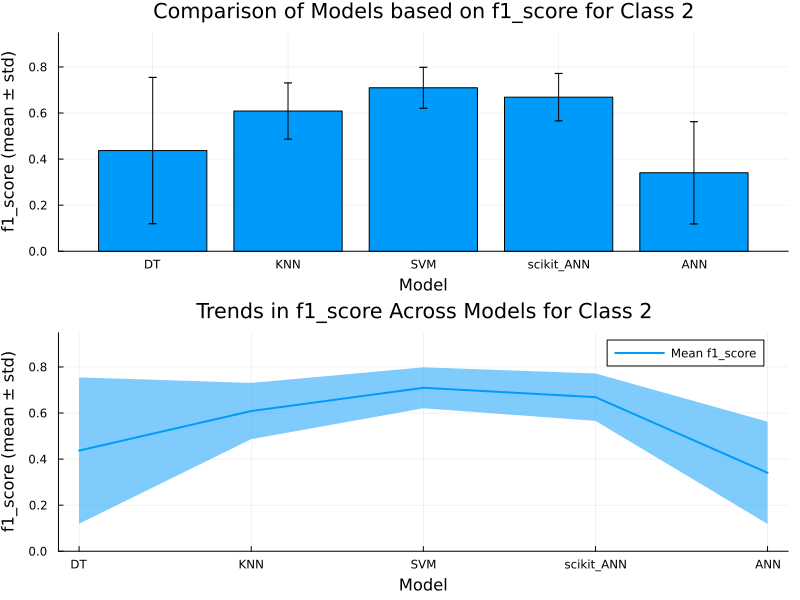

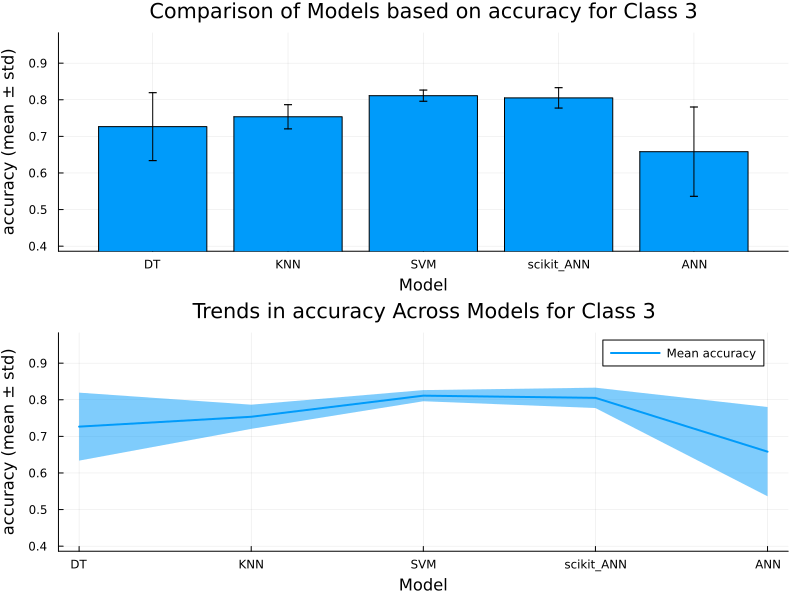

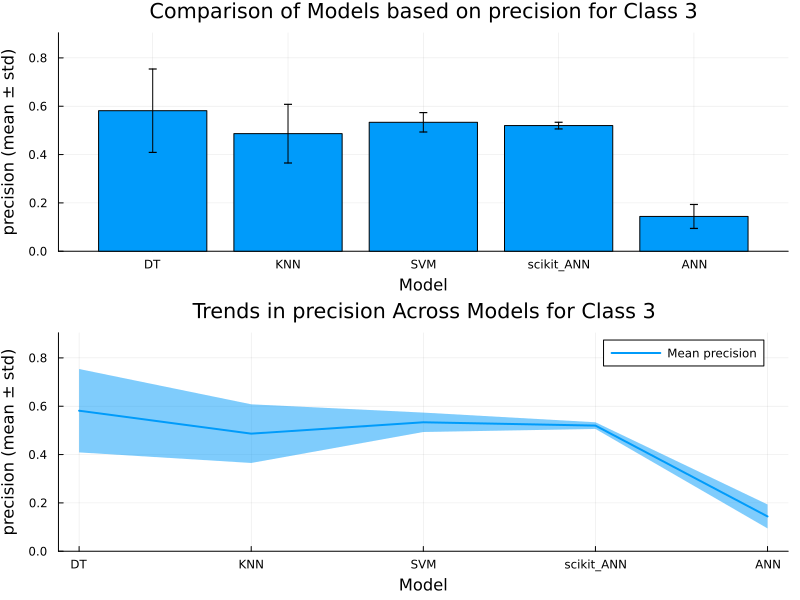

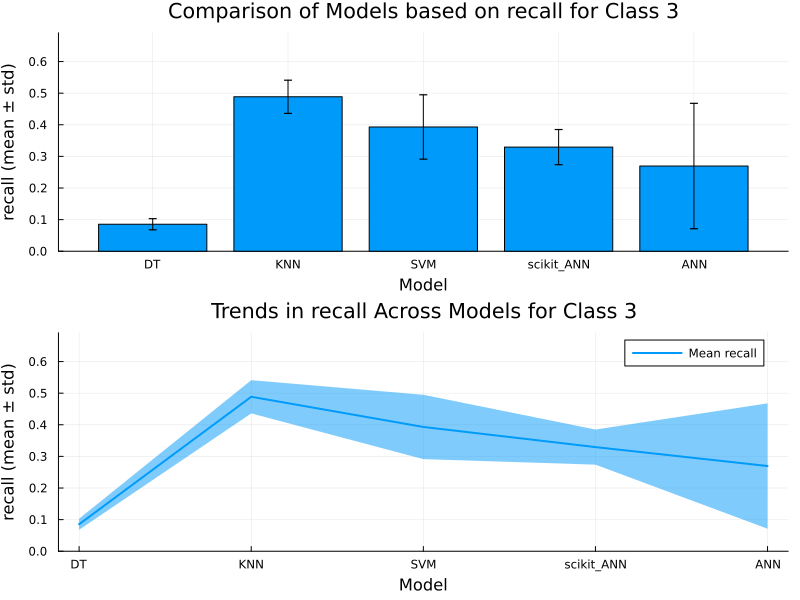

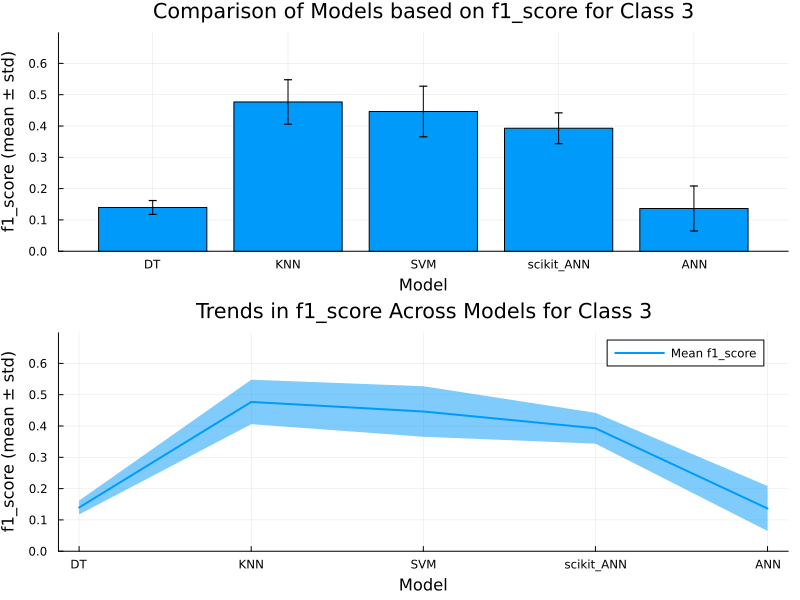

In [14]:
# Plot combined bar and line metrics per class
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir="./plots/Approach1/Classes", show=true, ylim=(0, 1))

In [15]:
# Generate and print the overall comparison table
generateComparisonTable(model_names, metrics, metric_maxes; sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.847 │     0.751 │  0.765 │     0.75 │
│ scikit_ANN │    0.845 │     0.743 │  0.764 │    0.742 │
│         DT │    0.822 │     0.725 │   0.74 │    0.694 │
│        ANN │    0.822 │     0.706 │  0.729 │    0.714 │
│        KNN │    0.809 │     0.714 │  0.716 │    0.711 │
└────────────┴──────────┴───────────┴────────┴──────────┘


In [16]:
# Generate and print the overall comparison table by class
generateComparisonTable(model_names, 3, metrics, metric_maxes_class; sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models for Class 1 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.872 │     0.895 │  0.946 │    0.854 │
│ scikit_ANN │    0.856 │     0.872 │  0.957 │    0.854 │
│        ANN │    0.854 │      0.78 │  0.758 │    0.769 │
│         DT │    0.852 │     0.845 │  0.995 │    0.828 │
│        KNN │    0.834 │     0.812 │   0.88 │    0.805 │
└────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Maximum Metrics Across Models for Class 2 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.862 │     0.884 │  0.955 │    0.859 │
│ scikit_ANN │    0.857 │     0.884 │  0.939 │    0.835 │
│         DT │    0.847 │     